In [1]:
# Load the TensorBoard notebook extension.

%reload_ext tensorboard
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pathlib
import pickle
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import seaborn as sns
import tensorboard
tensorboard.__version__

2021-11-15 09:40:03.520702: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/melodic/lib
2021-11-15 09:40:03.520736: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.4.0'

In [2]:
class NeuralNetwork():
    def __init__(self,activation_type, hidden_layers, loss, kernel_initializer, bias_initializer, data_type,epochs, modify_type):
        self.activation_type = activation_type
        self.hidden_layers = hidden_layers
        self.loss = loss
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer 
        self.data_type = data_type
        self.epochs = epochs
        self.modify_type = modify_type
        self.scaler = StandardScaler()
    def huber_loss(y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = tf.keras.backend.abs(error) < clip_delta
        squared_loss = 0.5 * tf.keras.backend.square(error)
        linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
        return tf.where(cond, squared_loss, linear_loss)
    def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
        return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))
    def prepare_data(self, dataset, func):        
        #add artificial features
        dataset['Air Temp Squared'] =  dataset['Air Temp']**2
        dataset['Abs Hum Squared'] =  dataset['Abs Hum']**2
        dataset['Air Temp*Abs Hum'] =  dataset['Air Temp']* dataset['Abs Hum']
        MicroclimateData['Air Temp Squared'] =  MicroclimateData['Air Temp']**2
        MicroclimateData['Abs Hum Squared'] =  MicroclimateData['Abs Hum']**2
        MicroclimateData['Air Temp*Abs Hum'] =  MicroclimateData['Air Temp']* MicroclimateData['Abs Hum']
        if self.data_type == 'WeatherStation'  and (func == 'test' or func == 'train'):
            X = dataset[['bldgname',
                        'Air Temp', 
                        'Abs Hum',
                        'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']]
            columns = ['Air Temp', 'Abs Hum',
                       'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']
            Y = dataset['CHWTON/SQFT']
        if self.data_type == 'Microclimate' and func == 'train':
            X = dataset[['bldgname',
                                  'Air Temp', 
                                  'Abs Hum',
                                  'Air Temp Squared',
                                  'Abs Hum Squared',
                                  'Air Temp*Abs Hum',
                                  'DSW Top', 
                                  'DSW North', 
                                  'DSW South', 
                                  'DSW East', 
                                  'DSW West', 
                                  'Shade North', 
                                  'Shade East', 
                                  'Shade West',
                                  'Shade South']]
            columns = ['Air Temp', 'Abs Hum', 'Air Temp Squared',
                        'Abs Hum Squared', 'Air Temp*Abs Hum', 'DSW Top',
                       'DSW North', 'DSW South', 'DSW East','DSW West',
                       'Shade North', 'Shade East', 'Shade West', 'Shade South',]
            Y = dataset['CHWTON/SQFT']
        if self.data_type == 'Microclimate' and func == 'test':
            X = dataset[['bldgname',
                        'Air Temp', 
                        'Abs Hum',
                        'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']]
            columns = ['Air Temp', 'Abs Hum',
                       'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']
            Y = dataset['CHWTON/SQFT']
        Y = Y.values.reshape(-1, 1)
        Y = self.scaler.fit_transform(Y)
        X = pd.get_dummies(X)
        StdSc2 = StandardScaler()
        X[columns] = StdSc2.fit_transform(X[columns])
#         X_train, X_test, y_train, y_test = self.split_unique(X, 'bldgname', columns, 0.2)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=0.2, 
                                                            random_state=20)
        return X_train, X_test, y_train, y_test
    def modify_data(self,dataset, mod_type):
#         print(dataset)
        if mod_type == '1':
            dataset['Air Temp'] = dataset['Air Temp'] - 1
#             print(dataset)
        elif mod_type == '0':
            dataset = dataset
        elif mod_type == '2':
            shade_list_north = dataset['Shade North'].tolist()
            print(len(shade_list_north))
#             print(shade_list_north)
            shade_list_north = [x + x*0.25 if int(x)!=1.0 else x for x in shade_list_north] 
#     if x!=1.0]
            print(len(shade_list_north))
            dataset.drop('Shade North', axis = 1, inplace = True)
            dataset['Shade North'] = shade_list_north  
            shade_list_south = dataset['Shade South'].tolist()
            shade_list_south = [x + x*0.25 if int(x)!=1.0 else x  for x in shade_list_south]
            dataset.drop('Shade South', axis = 1, inplace = True)
            dataset['Shade South'] = shade_list_south
            shade_list_east = dataset['Shade East'].tolist()
            shade_list_east = [x + x*0.25 if int(x)!=1.0 else x  for x in shade_list_east]
            dataset.drop('Shade East', axis = 1, inplace = True)
            dataset['Shade East'] = shade_list_east   
            shade_list_west = dataset['Shade West'].tolist()
            shade_list_west = [x + x*0.25 if int(x)!=1.0 else x  for x in shade_list_west]
            dataset.drop('Shade West', axis = 1, inplace = True)
            dataset['Shade West'] = shade_list_west
        x1,x2,y1,y2 = self.prepare_data(dataset, 'train')        
        return x1,x2,y1,y2
    def define_model(self):
        if self.data_type == 'WeatherStation' :
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(20, 
                                input_dim=16, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(30, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=16, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))           
        if self.data_type == 'Microclimate':
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(30, 
                                input_dim=25, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=25, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.05))
                model.add(Dense(1, activation = 'linear'))
        model.compile( loss = self.loss, 
                      optimizer = 'adam')
        model.summary()
        return model
    def train(self, dataset):
#         dataset_mod = self.modify_dataset(dataset,self.modify_type)
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'train')
        self.model = self.define_model()
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            callbacks=[tensorboard_callback])
    def fine_tune(self, dataset,alpha=0.001):
        self.model.trainable = True
        fine_tune_at = 2
        for layer in self.model.layers[:fine_tune_at]:
            layer.trainable =  False
        opt= Adam(learning_rate=alpha)
        self.model.compile(loss=self.loss, 
                           optimizer=opt)
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'test')
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            callbacks=[tensorboard_callback])
    def plot_curve_org(self,text):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        save_name = "./Data/plots-o/" + text + ".png"
        plt.savefig(save_name, bbox_inches='tight')
        plt.show()
    def plot_curve(self,text):
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(self.history.history["loss"],'r-x', label="Train Loss")
        ax.plot(self.history.history["val_loss"],'b-x', label="Validation Loss")
        ax.legend()
        ax.set_title(text)
        ax.grid(True)    
        save_name = "./Data/plots/" + text + ".png"
        plt.savefig(save_name, bbox_inches='tight')
  
    def evaluate(self, dataset, data_type ):
        call_type = 'test'
        if data_type == self.data_type:
            call_type = 'train'
        _, X_test, _, y_test = self.prepare_data(dataset,call_type)
        Y_preds = self.model.predict(X_test)
        RMSE = np.sqrt(metrics.mean_squared_error(y_test, Y_preds))
        R2_score = metrics.r2_score(y_test, Y_preds)
        print("The RMSE score for test dataset of "+ data_type +" is:", RMSE)
        print("The R2 score for test dataset of "+ data_type +" is:", R2_score)
        return RMSE,R2_score
        
                

In [12]:
MicroclimateData = pd.read_csv('./Data/all_buildings_limited.csv')
WeatherStationData = pd.read_csv('./Data/all_buildings_big.csv')
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df
def plot_predictions(MicroclimateModel,text, mod_type):
    date_time = MicroclimateData[['Date_Time',
                        'Month',
                        'Day',
                        'Hour',
                        'Minute']]

    x1,x2,y1,y2 = MicroclimateModel.prepare_data(MicroclimateData,'train')
    # Microclimate Model(NN)
    comb = [x1,x2]
    x1 = pd.concat(comb)
    Y_preds_original = MicroclimateModel.model.predict(x1)
    results_NN = undummify(x1).join(date_time)
    col = results_NN.pop('bldgname')
    results_NN.insert(0, 'bldgname', col)
    y1= np.concatenate((y1,y2))
    if mod_type !='3':
        x3,x4,y3,y4 = MicroclimateModel.modify_data(MicroclimateData, mod_type)
        # Microclimate Model(NN)
        comb1 = [x3,x4]
        x3 = pd.concat(comb1)
        Y_preds_new = MicroclimateModel.model.predict(x3)
        y3= np.concatenate((y3,y4))         
        results_NN['Actual'] = MicroclimateModel.scaler.inverse_transform(y1)
        results_NN['Time'] = results_NN['Date_Time'].str[11:16]
        results_NN['Predicted'] = MicroclimateModel.scaler.inverse_transform(Y_preds_new)
        results_NN['Microclimate_baseline'] = MicroclimateModel.scaler.inverse_transform(Y_preds_original) 
        month_NN = results_NN.loc[results_NN['Month'] == 8]
        day_NN = month_NN.loc[month_NN['Day'] == 1]
    Buildings = results_NN['bldgname'].unique()
    for bldg in Buildings:
        if mod_type == '0':
            string = './Data/Plots/sensitivity analysis/WithoutAnyMod/'+ send_text + bldg            
            bldg_NN = day_NN.loc[results_NN['bldgname']==bldg]
            values_NN = bldg_NN.sort_values(by=['Time'])
            values_NN['MicroModel Trained without'+ ' any modifications'] = values_NN['Predicted']
            values_NN['MicroModel Baseline'] = values_NN['Microclimate_baseline']            
            ax = values_NN.plot(x='Time',y='Actual', figsize = (8,8))
            values_NN.plot(x='Time',y='MicroModel Baseline',figsize = (8,8),ax=ax)
            plt.savefig(string, bbox_inches='tight')
        if mod_type == '1':
            print("enter")
            string = './Data/Plots/sensitivity analysis/WithTemperatureMod/'+ send_text + bldg
            bldg_NN = day_NN.loc[results_NN['bldgname']==bldg]
            values_NN = bldg_NN.sort_values(by=['Time'])
            values_NN['MicroModel Predictions after reducing temperature by 1 degree'] = values_NN['Predicted']
            values_NN['MicroModel Baseline'] = values_NN['Microclimate_baseline']
            ax = values_NN.plot(x='Time',y='Actual',grid = False, figsize = (8,8))
            values_NN.plot(x='Time',y='MicroModel Baseline',grid = False, figsize = (8,8),ax=ax)
            values_NN.plot(x='Time',y='MicroModel Predictions after reducing temperature by 1 degree',grid = False, figsize = (8,8),ax=ax)
            plt.savefig(string, bbox_inches='tight')
        if mod_type == '2':
            string = './Data/Plots/sensitivity analysis/WithShadeMod/'+ send_text + bldg
            bldg_NN = day_NN.loc[results_NN['bldgname']==bldg]
            values_NN = bldg_NN.sort_values(by=['Time'])
            values_NN['MicroModel Predictions after increasing Shade by 25%'] = values_NN['Predicted']
            values_NN['MicroModel Baseline'] = values_NN['Microclimate_baseline']
            ax = values_NN.plot(x='Time',y='Actual',grid = False, figsize = (8,8))
            values_NN.plot(x='Time',y='MicroModel Baseline',grid = False, figsize = (8,8),ax=ax)
            values_NN.plot(x='Time',y='MicroModel Predictions after increasing Shade by 25%',grid = False, figsize = (8,8),ax=ax)
            plt.savefig(string, bbox_inches='tight')
        if mod_type == '3':
            print("enter")
            string = './Data/Plots/sensitivity analysis/WithBothMod/'+ send_text + bldg
            x3,x4,y3,y4 = MicroclimateModel.modify_data(MicroclimateData, '1')
            # Microclimate Model(NN)
            comb1 = [x3,x4]
            x3 = pd.concat(comb1)
            Y_preds_new = MicroclimateModel.model.predict(x3)
            y3= np.concatenate((y3,y4))   
            x5,x6,y5,y6 = MicroclimateModel.modify_data(MicroclimateData, '2')
            comb2 = [x5,x6]
            x5 = pd.concat(comb2)
            Y_preds_new_1 = MicroclimateModel.model.predict(x5)
            y5= np.concatenate((y5,y6))   
            results_NN['Actual'] = MicroclimateModel.scaler.inverse_transform(y1)
            results_NN['Time'] = results_NN['Date_Time'].str[11:16]
            results_NN['Predicted'] = MicroclimateModel.scaler.inverse_transform(Y_preds_new)
            results_NN['Predicted_1'] = MicroclimateModel.scaler.inverse_transform(Y_preds_new_1)
            results_NN['Microclimate_baseline'] = MicroclimateModel.scaler.inverse_transform(Y_preds_original)
            month_NN = results_NN.loc[results_NN['Month'] == 8]
            day_NN = month_NN.loc[month_NN['Day'] == 1]
            bldg_NN = day_NN.loc[results_NN['bldgname']==bldg]
            values_NN = bldg_NN.sort_values(by=['Time'])
            values_NN['MicroModel Predictions after reducing temperature by 1 degree'] = values_NN['Predicted_1']
            values_NN['MicroModel Predictions after increasing Shade by 25%'] = values_NN['Predicted']
            values_NN['MicroModel Baseline'] = values_NN['Microclimate_baseline']
#             print(values_NN)
            ax = values_NN.plot(x='Time',y='Actual',grid = False, figsize = (8,8))
            values_NN.plot(x='Time',y='MicroModel Baseline',grid = False, figsize = (8,8) ,ax=ax)
            values_NN.plot(x='Time',y='MicroModel Predictions after increasing Shade by 25%',grid = False, figsize = (8,8),ax=ax)
            values_NN.plot(x='Time',y='MicroModel Predictions after reducing temperature by 1 degree',grid = False, figsize = (8,8),ax=ax)            
#             plt.savefig(string, bbox_inches='tight') 
            plt.savefig(string, bbox_inches='tight')    



2021-11-15 09:40:08.838923: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-15 09:40:08.861443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 09:40:08.861769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce MX130 computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 37.33GiB/s
2021-11-15 09:40:08.861889: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/melodic/lib
2021-11-15 09:40:08.861973: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] C

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                780       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 5,761
Trainable params: 5,761
Non-trainable params: 0
______________________________________________________

2021-11-15 09:40:09.315570: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-15 09:40:09.315629: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-11-15 09:40:09.318675: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-15 09:40:09.320043: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit/20211115-094008/train/plugins/profile/2021_11_15_09_40_09
2021-11-15 09:40:09.320702: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/fit/20211115-094008/train/plugins/profile/2021_11_15_09_40_09/biswas.trace.json.gz
2021-11-15 09:40:09.322238: I tensorflow/core/profiler/rpc/client/save_profile.c

3
enter
enter
enter
enter
enter
enter
enter
enter
enter
enter
enter
enter


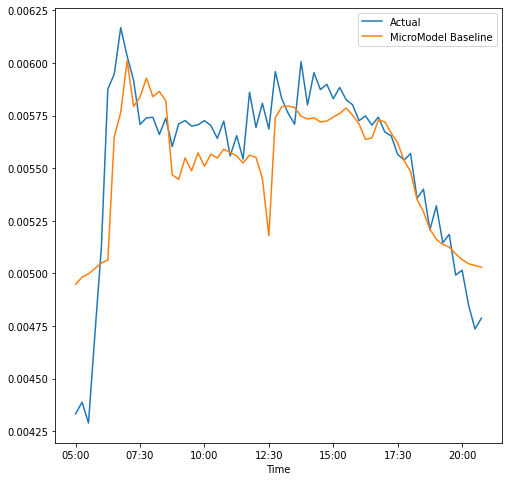

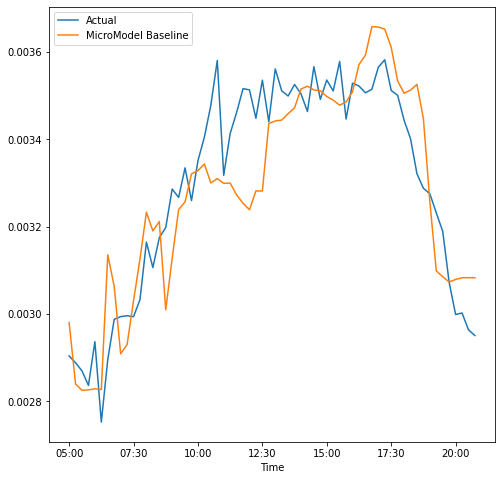

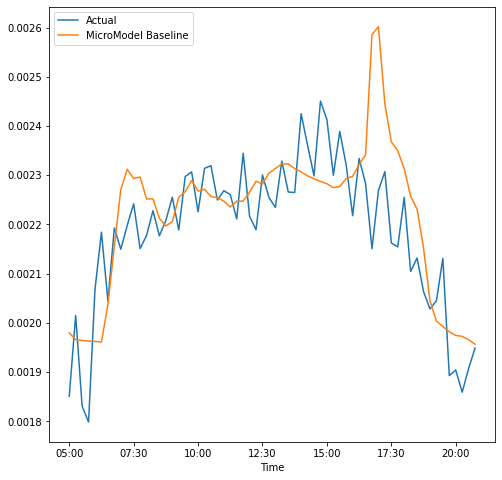

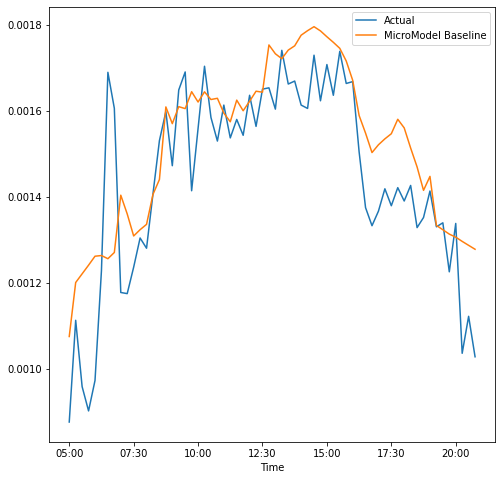

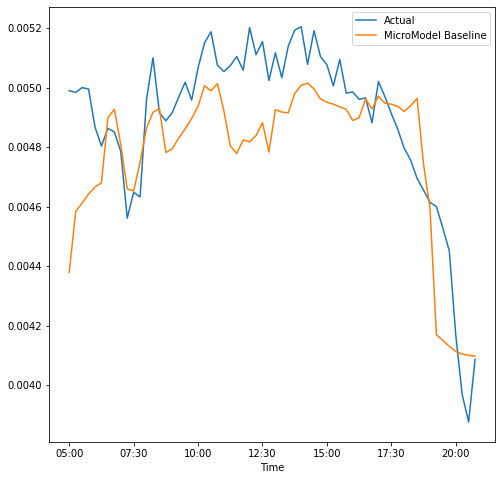

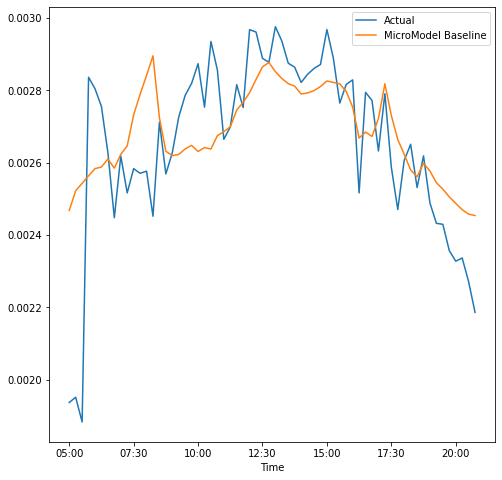

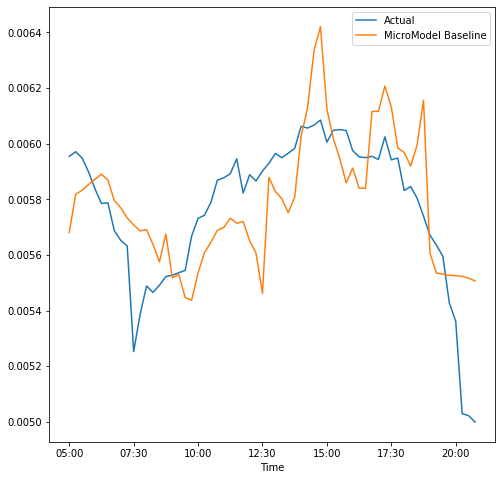

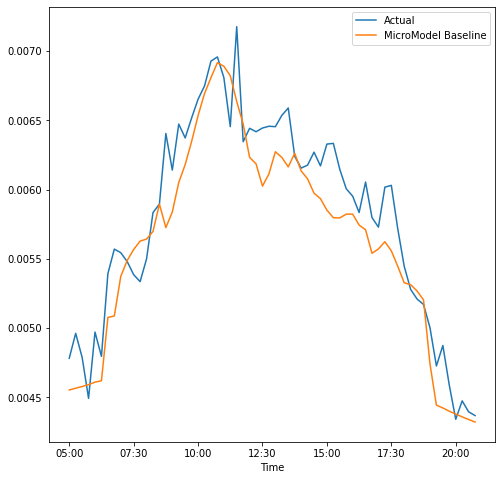

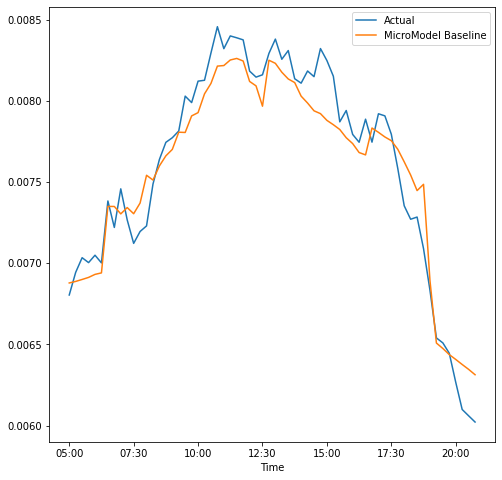

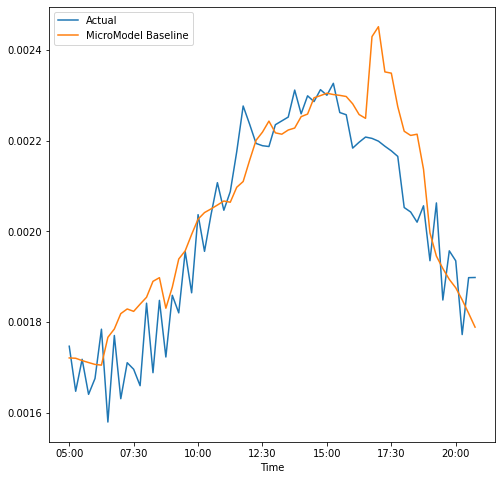

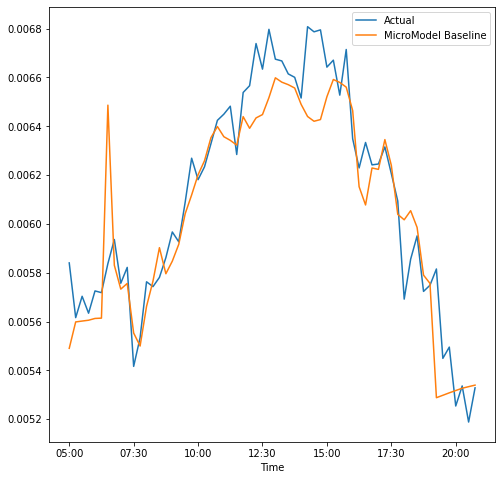

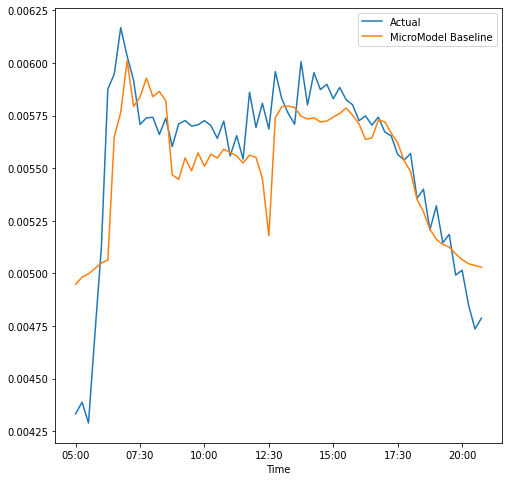

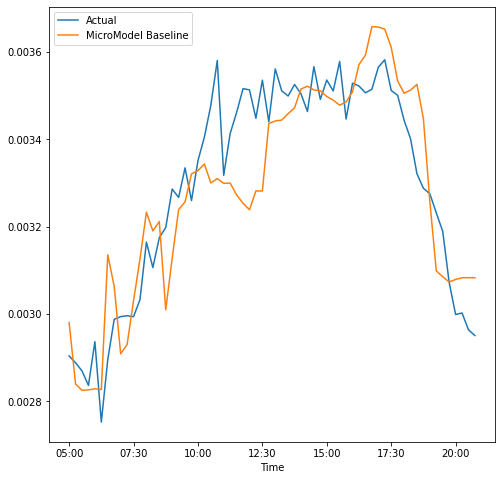

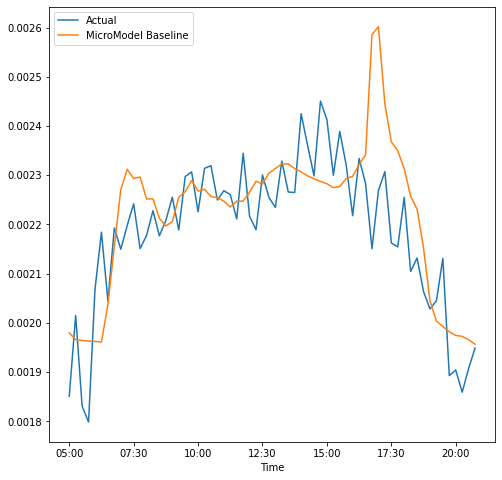

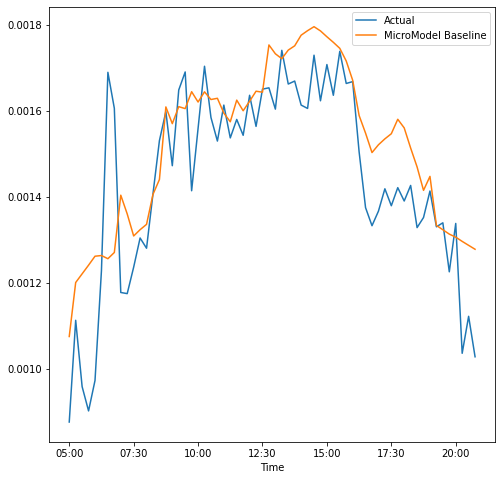

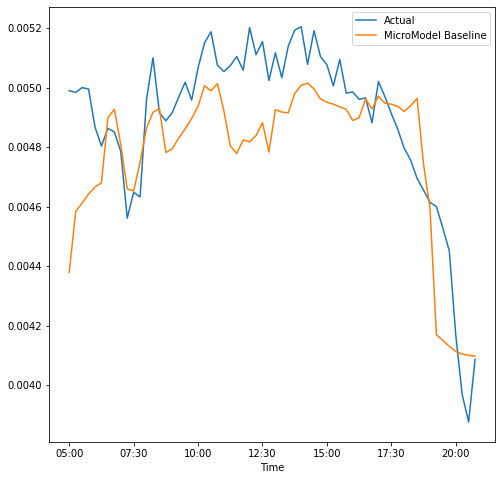

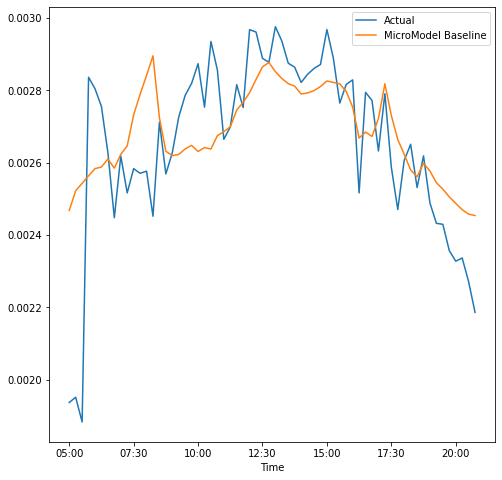

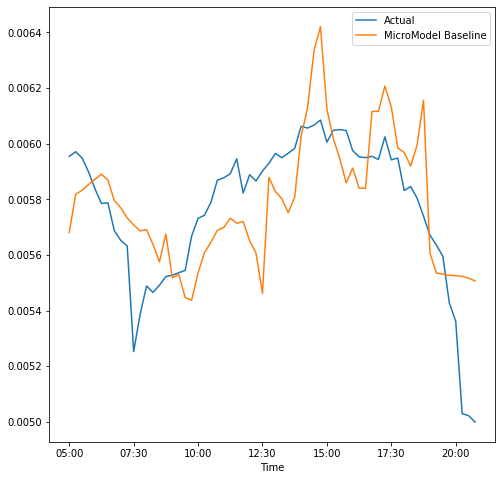

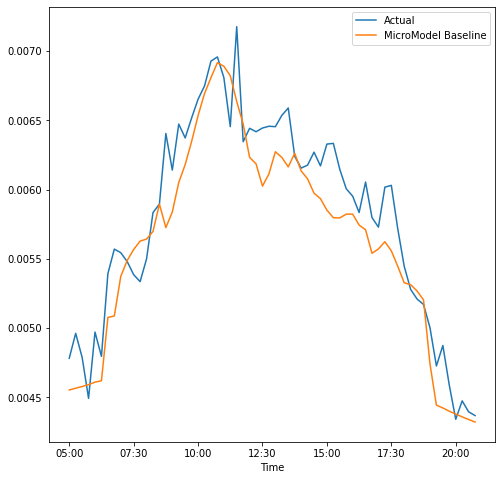

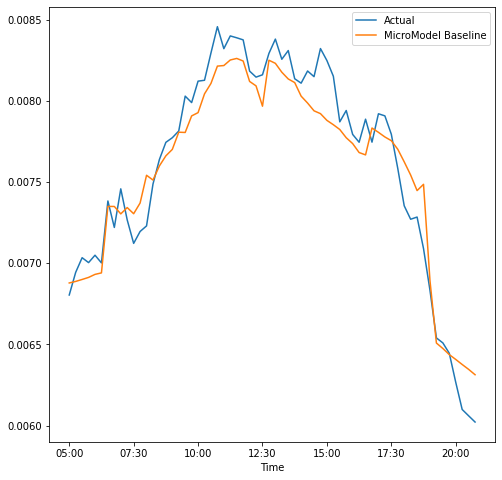

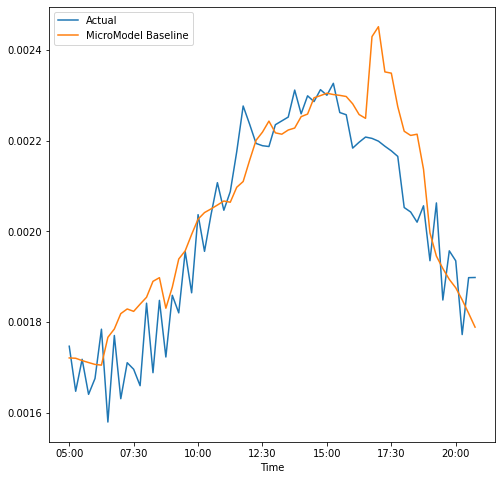

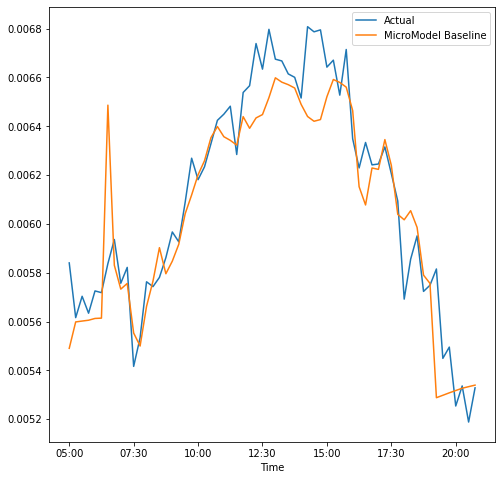

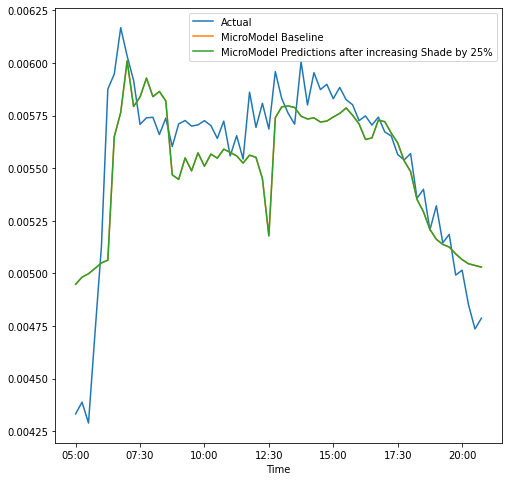

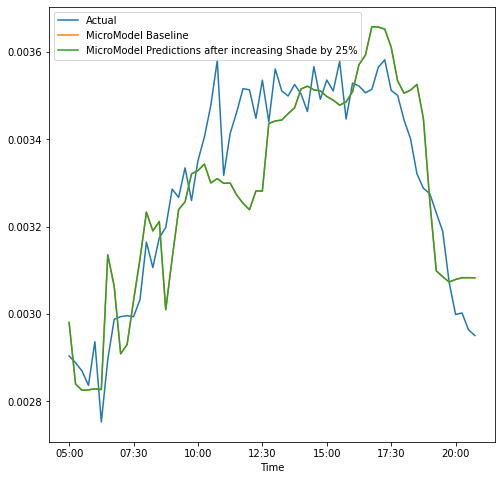

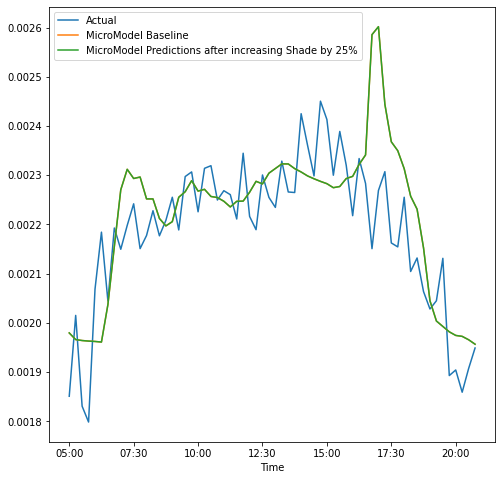

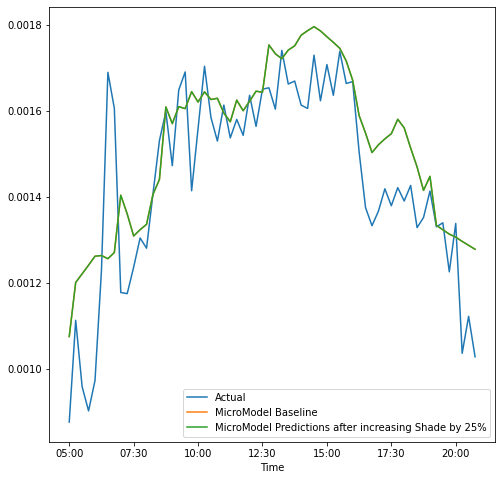

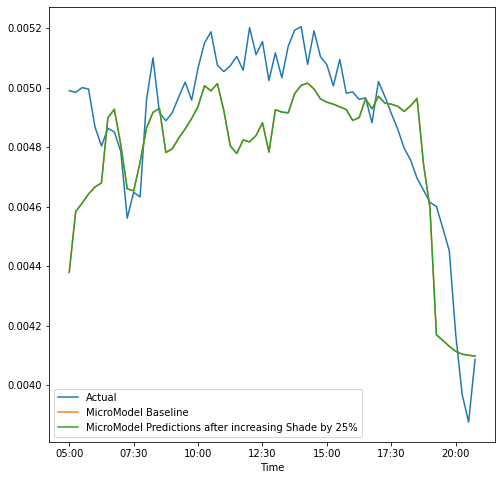

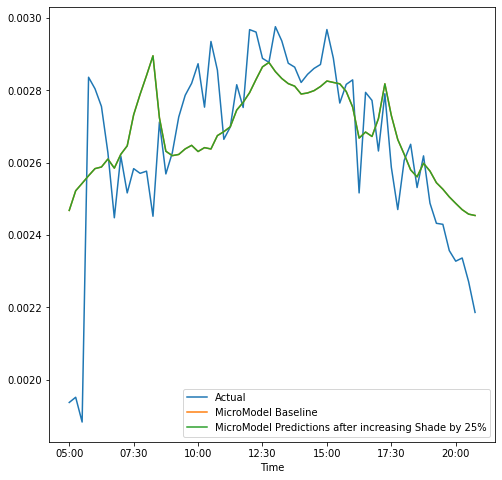

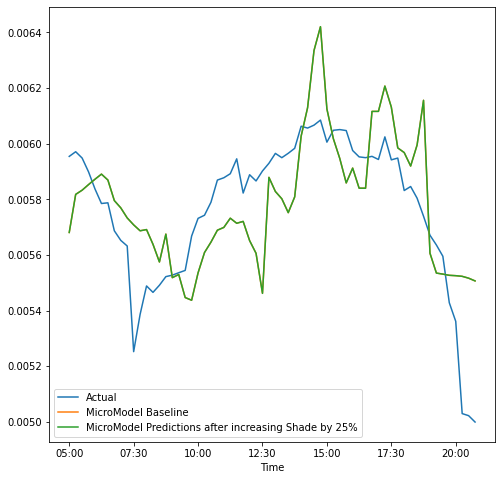

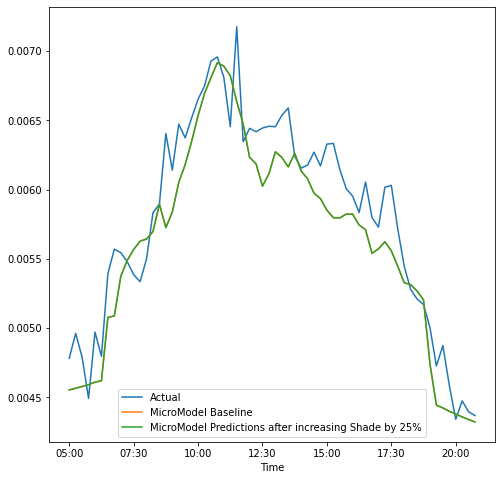

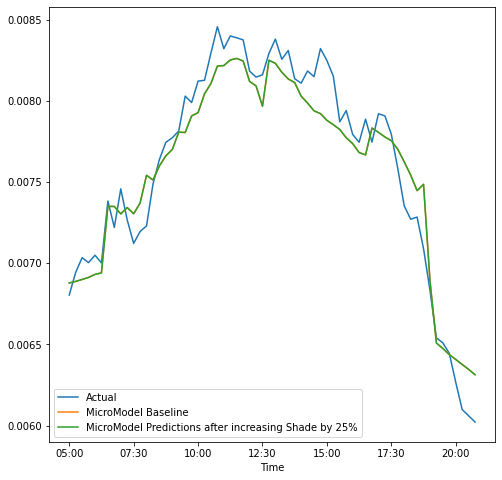

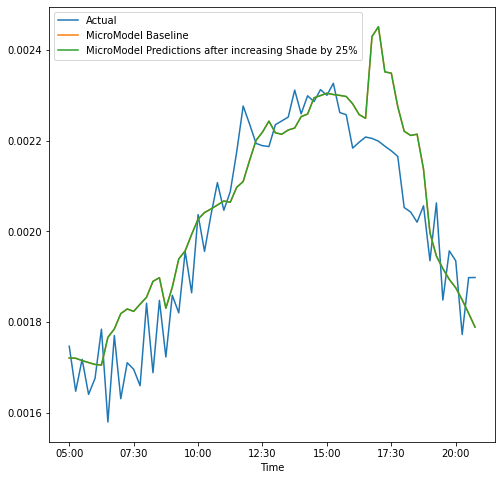

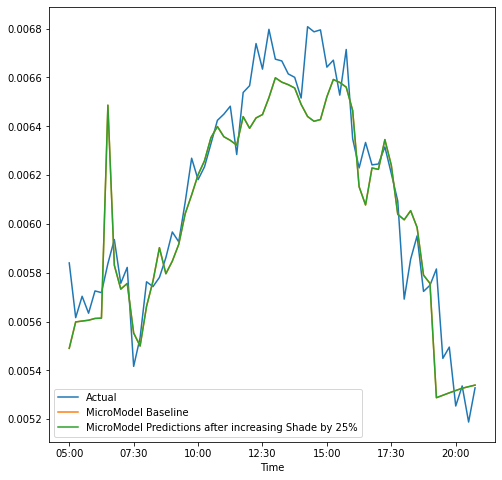

In [4]:
if __name__ == "__main__":
    # Train microclimate Model and save results for each parameter modification
    MicroclimateModel = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'Microclimate', 200, 0)
    MicroclimateModel.train(MicroclimateData)
    send_text = 'Microclimate Model without Temperature Decrease'
#     MicroclimateModel.plot_curve(send_text)
    plot_predictions(MicroclimateModel,send_text,'0')
    send_text = 'Microclimate Model without 25% Shade Increase'
#     MicroclimateModel.plot_curve_org(send_text)
    plot_predictions(MicroclimateModel,send_text,'0')
    modify_type_list = ['3']
    for modify_type in modify_type_list:
        print(modify_type)
        if modify_type == '1':            
            send_text = 'Microclimate Model with Temperature Decrease'
#             MicroclimateModel.plot_curve(send_text)
            plot_predictions(MicroclimateModel,send_text,modify_type)
        if modify_type == '2':            
            send_text = 'Microclimate Model with 25% Shade Increase'
#             MicroclimateModel.plot_curve(send_text)
            plot_predictions(MicroclimateModel,send_text,modify_type)
        if modify_type == '3':  
            print("enter")
            send_text = 'Microclimate Model with both Temperature Decrease and 25% Shade Increase'
#             MicroclimateModel.plot_curve(send_text)
            plot_predictions(MicroclimateModel,send_text,'3')


enter
9589
9589
enter
9589
9589
enter
9589
9589
enter
9589
9589
enter
9589
9589
enter
9589
9589
enter
9589
9589
enter
9589
9589
enter
9589
9589
enter
9589
9589
enter
9589
9589


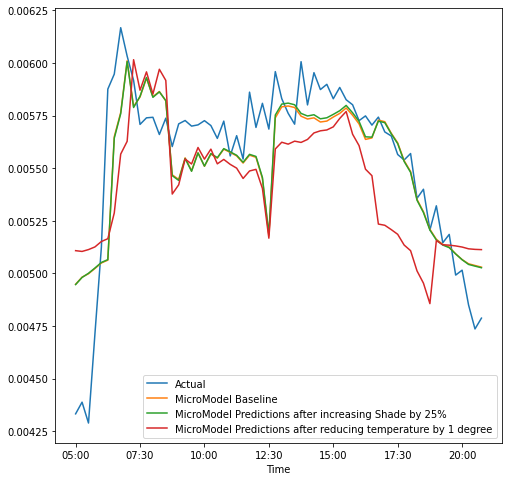

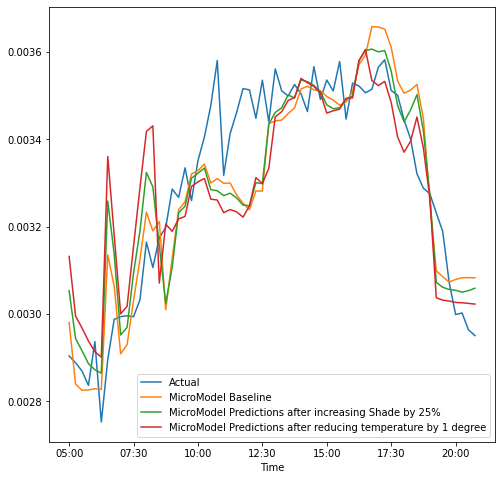

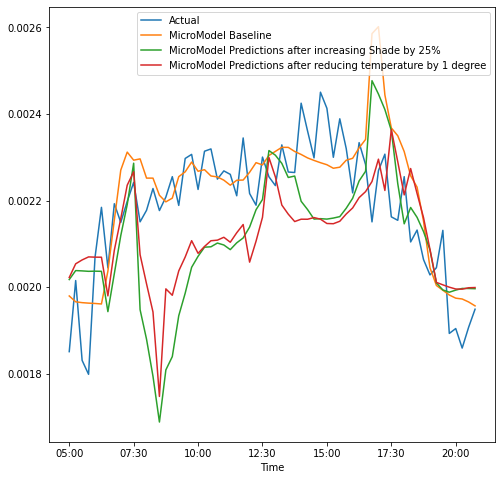

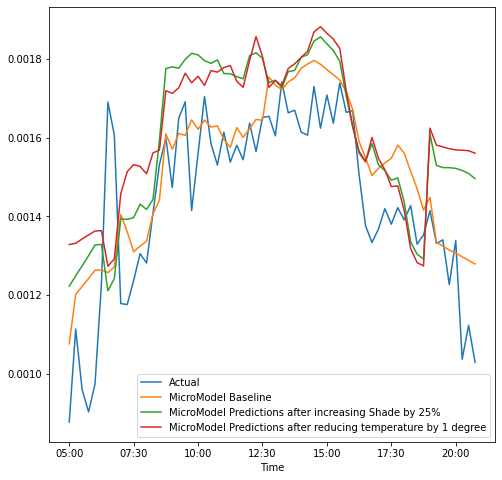

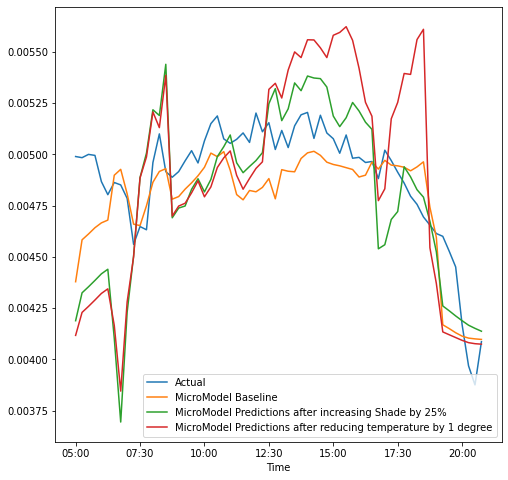

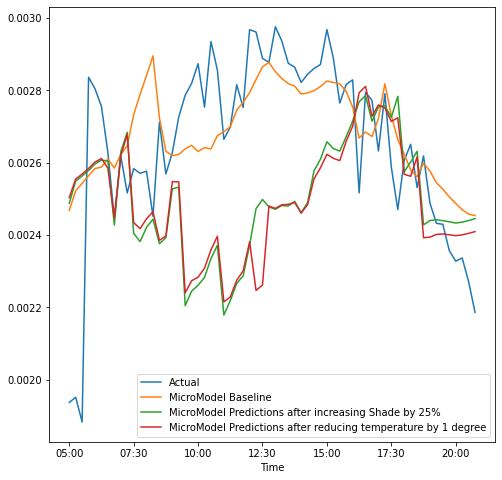

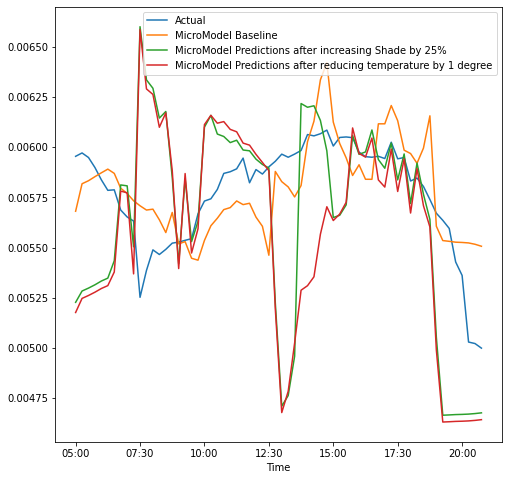

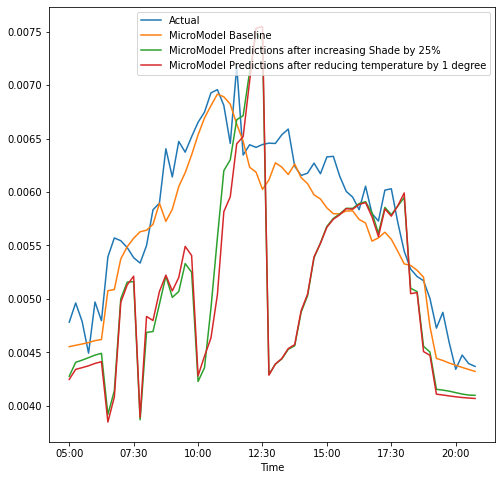

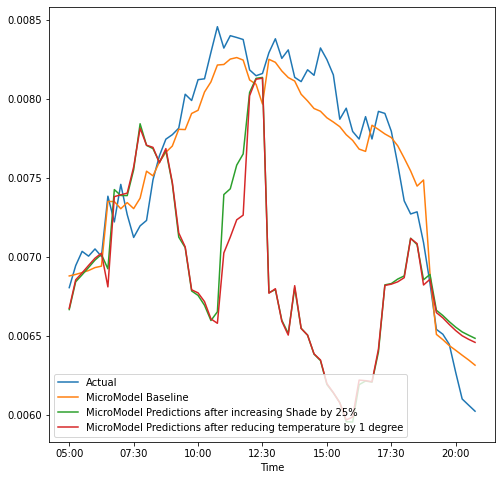

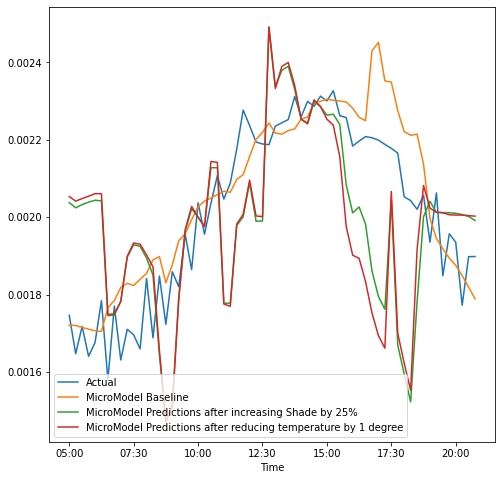

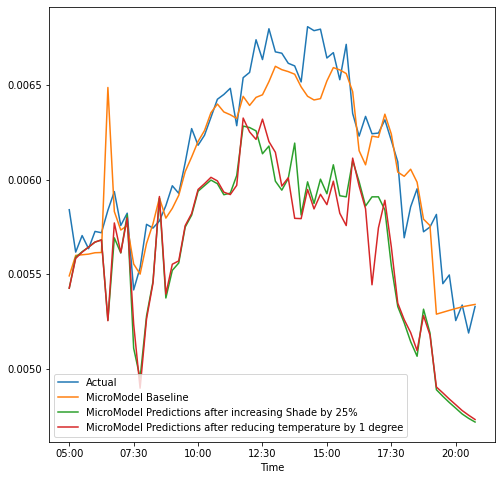

In [13]:
send_text = 'Microclimate Model with both Temperature Decrease and 25% Shade Increase'
#             MicroclimateModel.plot_curve(send_text)
plot_predictions(MicroclimateModel,send_text,'3')
